### lecture 16 - SARIMA(p,d,q)(P,D,Q)m, Seasonal Autoregressive Integrated Moving Averages

We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.

In [40]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose # for ETS Plots
from pmdarima import auto_arima # for determining ARIMA orders
import warnings
warnings.filterwarnings("ignore")

In [41]:
df = pd.read_csv('./dataset/co2_mm_mlo.csv')

In [42]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>

In [43]:
df['date'] = pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})

In [44]:
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          729 non-null    int64         
 1   month         729 non-null    int64         
 2   decimal_date  729 non-null    float64       
 3   average       722 non-null    float64       
 4   interpolated  729 non-null    float64       
 5   date          729 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.3 KB


In [46]:
df = df.set_index('date')

In [47]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [48]:
df.index.freq = 'MS'

In [49]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


<Axes: xlabel='date'>

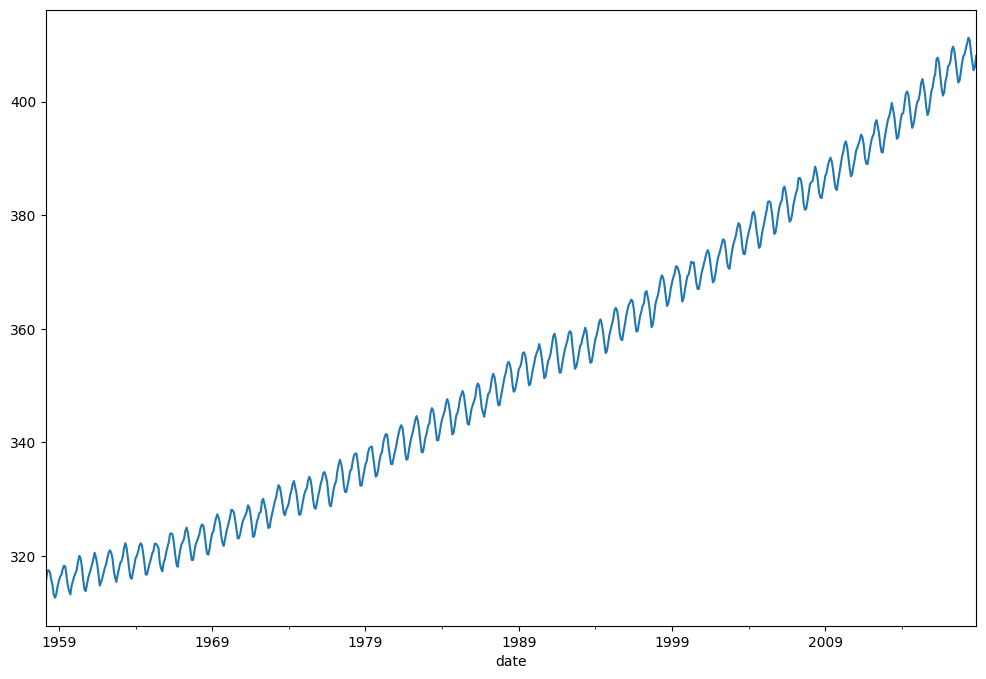

In [50]:
df['interpolated'].plot(figsize=(12,8)) # clear seasonality

In [51]:
results = seasonal_decompose(df['interpolated'],model='add')

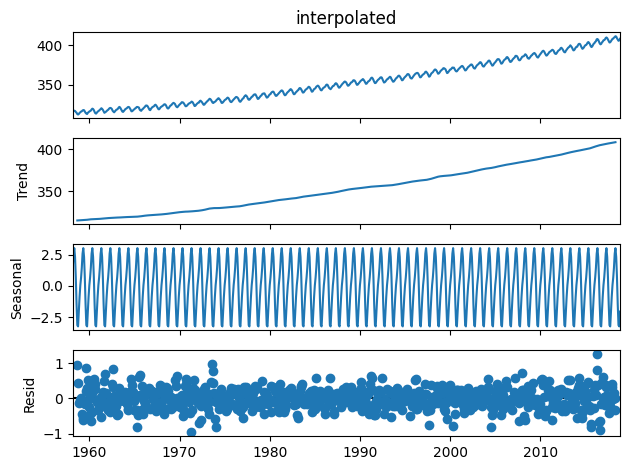

In [52]:
results.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

#### auto_arima

In [53]:
auto_arima(df['interpolated'],seasonal=True,m=12).summary() # annual seasonality so m=12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.251
Date:                            Mon, 30 Dec 2024   AIC                            424.502
Time:                                    16:32:55   BIC                            452.044
Sample:                                03-01-1958   HQIC                           435.130
                                     - 11-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3514      0.045      7.740      0.000       0.262       0.440
ar.L2          0.0876      0.021      4.155      0.000       0.046       0.129
ma.L1         -0.7068      0.041    -17.068      0.000      -0.788      -0.626
ar.S.L12       0.9996      0.000   2944.118      0.000       0.999       1.000
ma.S.L12      -0.8671      0.021    -40.749      0.000      -0.909      -0.825
sigma2         0.0956      0.005     20.387      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.50
Prob(Q):                              0.79   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### train and test split

In [54]:
len(df)

729

In [55]:
train = df.iloc[:717]

In [56]:
test = df.iloc[717:]

In [57]:
model = SARIMAX(train['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))

In [58]:
results = model.fit()

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.884
Date:                            Mon, 30 Dec 2024   AIC                            415.767
Time:                                    16:32:58   BIC                            443.209
Sample:                                03-01-1958   HQIC                           426.364
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3467      0.052      6.624      0.000       0.244       0.449
ar.L2          0.0824      0.009      9.275      0.000       0.065       0.100
ma.L1         -0.7009      0.044    -15.840      0.000      -0.788      -0.614
ar.S.L12       0.9996      0.000   2554.323      0.000       0.999       1.000
ma.S.L12      -0.8653      0.023    -37.898      0.000      -0.910      -0.821
sigma2         0.0954      0.005     20.730      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.67
Prob(Q):                              0.80   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
start = len(train)

In [61]:
end = len(train) + len(test) - 1

In [62]:
predictions = results.predict(start,end,typ='levels').rename('SARIMA predictions')

<Axes: xlabel='date'>

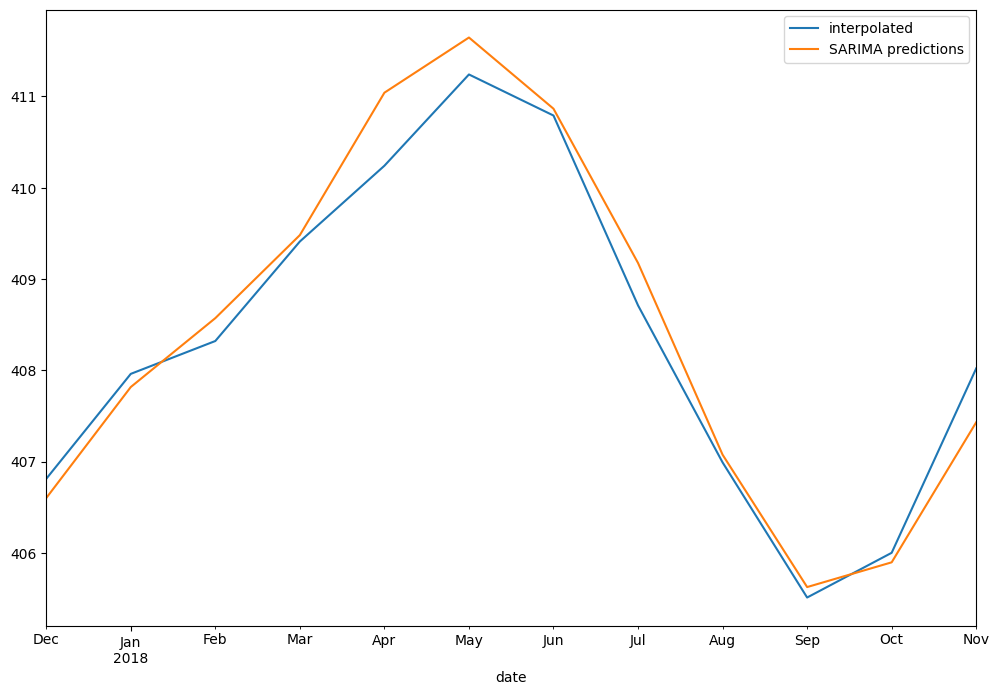

In [63]:
test['interpolated'].plot(legend=True,figsize=(12,8))
predictions.plot(legend=True)

pretty on target predictions

#### model evaluation

In [64]:
from statsmodels.tools.eval_measures import rmse

In [65]:
error = rmse(test['interpolated'],predictions)

In [66]:
error

0.35797743053390463

In [67]:
test['interpolated'].mean()

408.3333333333333

#### forecast into the unknown future

In [68]:
model = SARIMAX(df['interpolated'],order=(2,1,1),seasonal_order=(1,0,1,12))

In [69]:
results = model.fit()

In [70]:
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA forecast')

<Axes: xlabel='date'>

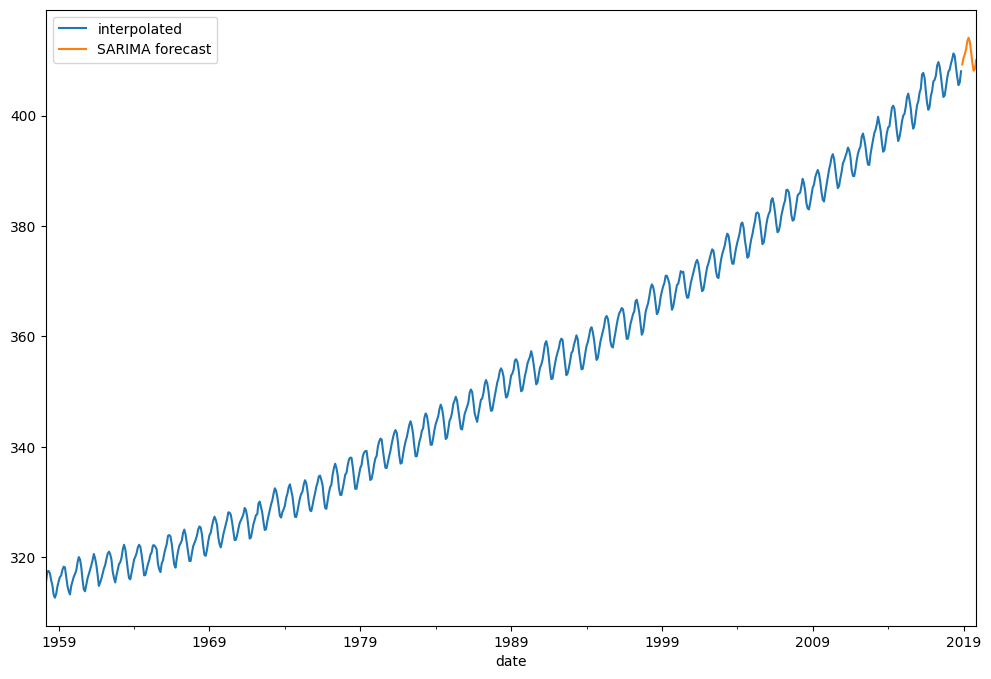

In [71]:
df['interpolated'].plot(legend=True,figsize=(12,8))
fcast.plot(legend=True)